## Pembuatan Model Deep Learning LSTM-GRU, Prediksi Harga Komoditas Pangan Pasar Kramat Kota Cirebon.

Authored by : Hafiz Caniago.

## Setup Variabel

In [63]:
# Dapat Dirubah
## List Komoditas
comodity_list = ['bawang_merah', 'cabai_merah_besar', 'cabai_merah_keriting', 'cabai_rawit_hijau', 'cabai_rawit_merah'];
# Pilih Komoditas :
# 0 = bawang merah, 1 = cabai merah besar, 2 = cabai merah keriting,
# 3 = cabai rawit hijau, 4 = cabai rawit merah
comodity_selected = 0;

## Hyperparameter
set_max_epochs = 100; # 100, 150
set_neurons = 16; # 16, 32, 64
set_batch_size = 32; # 32

# Tidak Dirubah
set_test_size = 0.2; # Panjang Data Test
set_window_size = 30; # Panjang Data Pola Time Series

## Kode Tambahan
y_axis_title_comodity = ['Harga Bawang Merah', 'Harga Cabai Merah Besar',
                         'Harga Cabai Merah Keriting', 'Harga Cabai Rawit Hijau',
                         'Harga Cabai Rawit Merah']
chart_title = 'Historis Data ' + y_axis_title_comodity[comodity_selected]

## Import Library

In [64]:
# numpy & matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Sklearn Lib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error

# Tensorflow
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import LSTM, GRU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# JobLib
import joblib

In [65]:
# Export requirements.txt
!pip freeze > requirements.txt

## Data Preparation


In [66]:
# Baca CSV File
df = pd.read_csv('/content/dataset.csv')

In [67]:
# Preview Data
df

,date,cabai_merah_besar,cabai_merah_keriting,cabai_rawit_hijau,cabai_rawit_merah,bawang_merah
0,2021-05-03,39000,37000,32000,60000,29000
1,2021-05-04,39000,39000,29000,70000,29000
2,2021-05-05,37000,37000,28000,70000,29000
3,2021-05-06,39000,39000,28000,70000,29000
4,2021-05-07,39000,40000,30000,70000,31000
...,...,...,...,...,...,...
1092,2024-04-29,60000,60000,32000,49000,60000
1093,2024-04-30,60000,60000,30000,49000,60000
1094,2024-05-01,59500,60000,33000,49000,57500
1095,2024-05-02,59000,60000,36000,49000,55000


In [68]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  1097 non-null   object
 1   cabai_merah_besar     1097 non-null   int64 
 2   cabai_merah_keriting  1097 non-null   int64 
 3   cabai_rawit_hijau     1097 non-null   int64 
 4   cabai_rawit_merah     1097 non-null   int64 
 5   bawang_merah          1097 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 51.6+ KB


In [69]:
df.describe()

,cabai_merah_besar,cabai_merah_keriting,cabai_rawit_hijau,cabai_rawit_merah,bawang_merah
count,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000
mean,42176.162261,46441.886964,39445.077484,58527.803099,33160.893345
std,19287.677455,18727.108870,13950.812254,20627.575250,8924.155856
min,16000.000000,17000.000000,17000.000000,24500.000000,19000.000000
25%,29000.000000,34500.000000,31000.000000,43682.000000,28500.000000
50%,35500.000000,41000.000000,36000.000000,54000.000000,31000.000000
75%,50000.000000,60000.000000,46333.000000,70000.000000,35500.000000
max,110000.000000,105000.000000,100000.000000,120000.000000,70000.000000




> dari hasil deskripsi dari data, terdapat 5 kolom dataset komoditas pangan dengan masing masing data berjumlah 1097 baris.
- harga cabai merah besar
  - max : 110,000
  - min : 16,000
- harga cabai merah keriting
  - max : 105,000
  - min : 17,000
- harga cabai rawit hijau
  - max : 100,000
  - min : 17,000
- harga cabai rawit merah
  - max : 120,000
  - min : 16,000
- harga bawang merah
  - max : 70,000
  - min : 19,000



> Kode dibawah ini akan menstransformasikan kolom 'date' dari tipe data object ke tipe data date, serta melakukan konversi bentuk tanggal untuk 'date' jika tidak berformat 'Y-m-d'. serta melakukan konversi tipe data harga ke dalam bentuk float.



In [70]:
# Mentransformasikan Data ke Format Datetime
df.date = pd.to_datetime(df.date, format = '%Y-%m-%d')
df.sort_values(by='date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Mentransformasikan Data ke Format Integer (Harga Pangan tidak perlu koma)
columns_to_convert = df.columns[1:]  # Exclude the 'date' column
df[columns_to_convert] = df[columns_to_convert].astype('float64')

In [71]:
# Dataset info after transformation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1097 non-null   datetime64[ns]
 1   cabai_merah_besar     1097 non-null   float64       
 2   cabai_merah_keriting  1097 non-null   float64       
 3   cabai_rawit_hijau     1097 non-null   float64       
 4   cabai_rawit_merah     1097 non-null   float64       
 5   bawang_merah          1097 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 51.6 KB


In [72]:
# Preview Data after transformation
df

,date,cabai_merah_besar,cabai_merah_keriting,cabai_rawit_hijau,cabai_rawit_merah,bawang_merah
0,2021-05-03,39000.0,37000.0,32000.0,60000.0,29000.0
1,2021-05-04,39000.0,39000.0,29000.0,70000.0,29000.0
2,2021-05-05,37000.0,37000.0,28000.0,70000.0,29000.0
3,2021-05-06,39000.0,39000.0,28000.0,70000.0,29000.0
4,2021-05-07,39000.0,40000.0,30000.0,70000.0,31000.0
...,...,...,...,...,...,...
1092,2024-04-29,60000.0,60000.0,32000.0,49000.0,60000.0
1093,2024-04-30,60000.0,60000.0,30000.0,49000.0,60000.0
1094,2024-05-01,59500.0,60000.0,33000.0,49000.0,57500.0
1095,2024-05-02,59000.0,60000.0,36000.0,49000.0,55000.0


In [73]:
# Panjang Data
print("Panjang Data : ", len(df))

Panjang Data :  1097


In [74]:
# Check Duplicates data
df.duplicated(subset=['date'])

,0
0,False
1,False
2,False
3,False
4,False
...,...
1092,False
1093,False
1094,False
1095,False


In [75]:
# Check Null Data
df.isnull().sum().sum()

np.int64(0)

### Preview Chart Comodity

In [76]:
# Ploting Chart Data Historis
fig = px.line(y=df[comodity_list[comodity_selected]], x=df.date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Waktu Historis",
                  yaxis_title=y_axis_title_comodity[comodity_selected],
                  title={'text': chart_title, 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

### Normalisasi, Split Data Training & Testing, Pembentukan Pola Time Series



> Mempersiapkan instance scaler dan mengeluarkan file format scaler.pkl agar model bisa digunakan di luar google colab. (contoh : inference menggunakan model dan skalar yang sudah di export)



In [77]:
# Data Scaling
scaler = MinMaxScaler()
scaler.fit(df[comodity_list[comodity_selected]].values.reshape(-1,1))

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']



> menyiapkan variable yang menampung jumlah atau ukuran data testing (20%)



In [78]:
# Set Panjang Data Test
test_size = int(len(df) * set_test_size)
test_size

219



> Melakukan visualisasi untuk menggambarkan seberapa banyak data training dan data testing



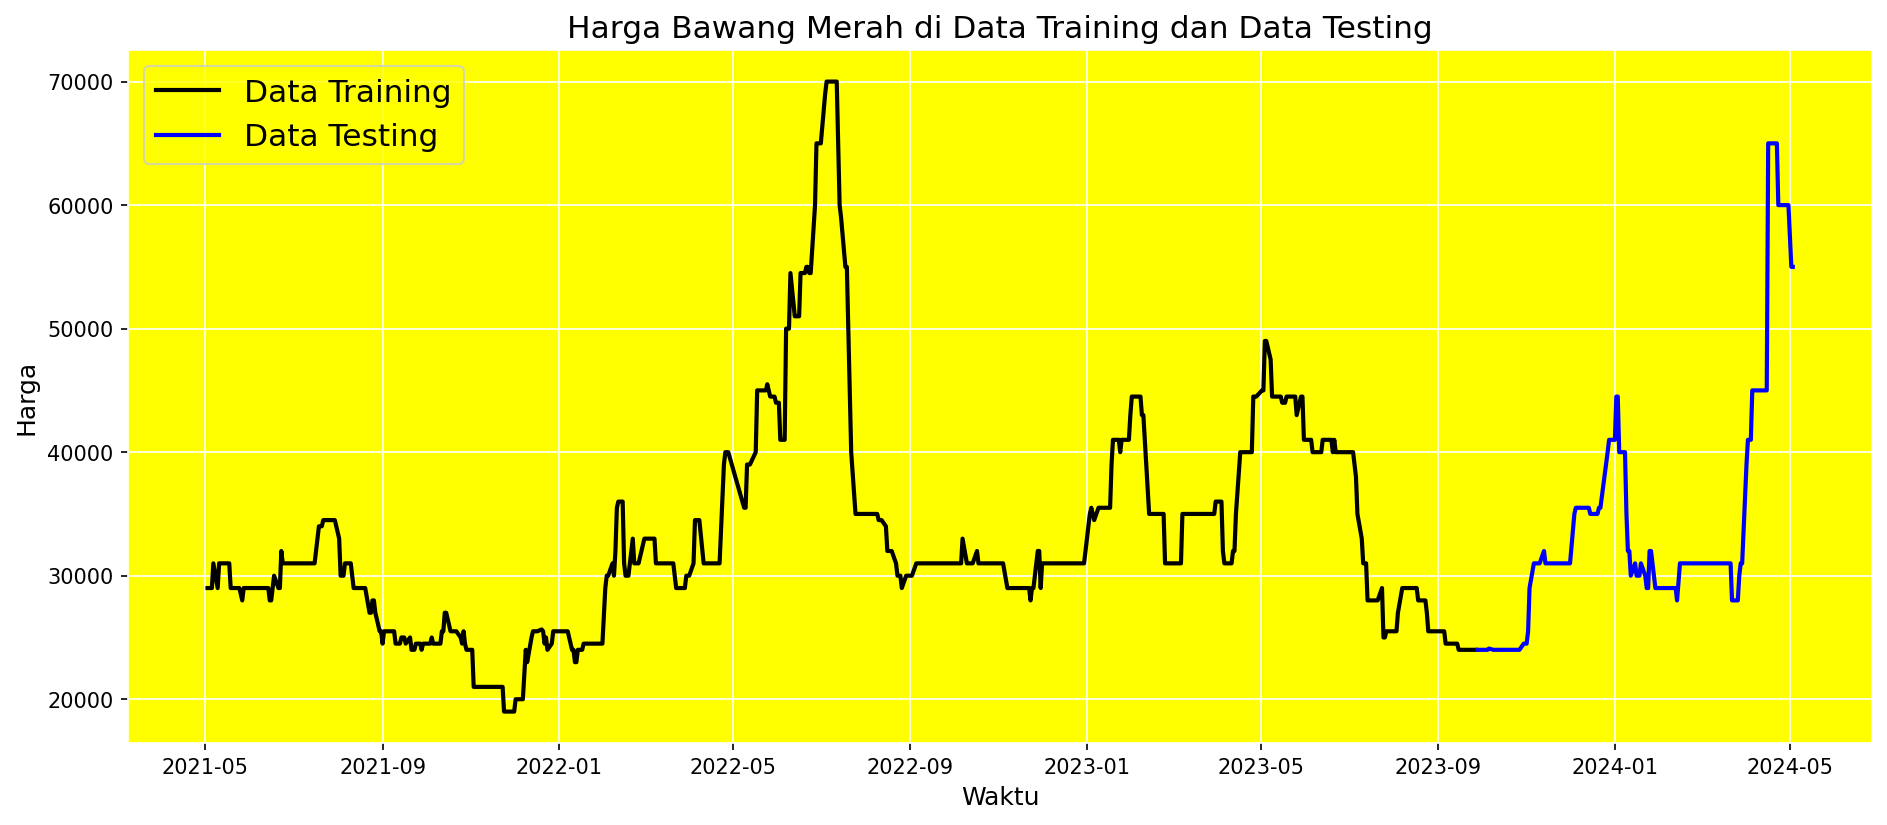

In [79]:
# Ploting Data Training dan Test
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.date[:-test_size], df[comodity_list[comodity_selected]][:-test_size], color='black', lw=2)
plt.plot(df.date[-test_size:], df[comodity_list[comodity_selected]][-test_size:], color='blue', lw=2)
plt.title(y_axis_title_comodity[comodity_selected] + ' di Data Training dan Data Testing', fontsize=15)
plt.xlabel('Waktu', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.legend(['Data Training', 'Data Testing'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

- menyiapkan ukuran window_size
- menyiapkan data training (80%) data
- melakukan normalisasi pada data training dan membatasi angka koma menjadi 6 agar proses komputasi bisa lebih ringan.
- menyiapkan variable X_Train yang menyimpan data dalam bentuk window, dengan setiap window tersebut memiliki panjang 30 data (cek deklarasi di awal).
- menyiapkan variable y_train sebagai nilai aktual yang akan diprediksi menggunakan data pada setiap window.

In [80]:
# Panjang data Loopback x hari
window_size = set_window_size

# Persiapkan data Training 80% dari data, dan normalisasikan
train_data = df[comodity_list[comodity_selected]][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

# Membulatkan hingga 6 angka di belakang koma
train_data = np.round(train_data, 6)

# Siapkan Variable untuk menampung data Train, disesuaikan dengan data loopback yaitu 30
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])

In [81]:
print("Panjang Data Train : ", len(train_data))
print("Panjang Data Train X - loopback : ", len(X_train))
print("Panjang Data Train y - loopback : ", len(y_train))

Panjang Data Train :  878
Panjang Data Train X - loopback :  848
Panjang Data Train y - loopback :  848




> sama saja dengan proses pembentukan pada data training, pembagian data testing menggunakan 20% dari dataset



In [82]:
# Persiapkan data test
test_data = df[comodity_list[comodity_selected]][-test_size-30:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

# Membulatkan hingga 6 angka di belakang koma
test_data = np.round(test_data, 6)

# Siapkan Variable untuk menampung data Test, disesuaikan dengan data loopback yaitu 30
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-30:i, 0])
    y_test.append(test_data[i, 0])

In [83]:
print("Panjang Data Test : ", len(test_data))
print("Panjang Data Test X - loopback : ", len(X_test))
print("Panjang Data Test y - loopback : ", len(y_test))

Panjang Data Test :  249
Panjang Data Test X - loopback :  219
Panjang Data Test y - loopback :  219




> setelahnya data tersebut akan dirubah menjadi bentuk array dan akan dilakukan reshape agar format datanya menjadi format tensor (format yang digunakan pada pelatihan deep learning)



In [84]:
# Now X_train and X_test are nested lists (two-dimensional lists) and y_train is a one-dimensional list.
# We need to convert them to numpy arrays with a higher dimension,
# which is the data format accepted by TensorFlow when training the neural network:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (848, 30, 1)
y_train Shape:  (848, 1)
X_test Shape:   (219, 30, 1)
y_test Shape:   (219, 1)


## Training Model


> Training model dilakukan dengan arsitektur sebagai berikut :



In [85]:
# Create LSTM + GRU Model
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = set_neurons, return_sequences=True)(input1)
    x = GRU(units = set_neurons)(x)  # Setting return_sequences=False to get 2D output
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer=Adam())
    model.summary()

    return model



> Proses training model dilakukan juga dengan memanfaatkan model checkpoint agar model terbaik dapat diperoleh dari pelatihan dan disimpan dalam bentuk h5 file.



In [86]:
# Training Model
model = define_model()
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# Fit the model with the checkpoint callback
history = model.fit(X_train, y_train, epochs=set_max_epochs, batch_size=set_batch_size, validation_split=0.1, verbose=1, callbacks=[checkpoint])
# Load the best model saved during training
model = load_model('best_model.h5')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 16)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0556
Epoch 1: val_loss improved from inf to 0.02081, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0528 - val_loss: 0.0208
Epoch 2/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0107
Epoch 2: val_loss improved from 0.02081 to 0.00701, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0105 - val_loss: 0.0070
Epoch 3/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050
Epoch 3: val_loss improved from 0.00701 to 0.00557, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0050 - val_loss: 0.0056
Epoch 4/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051
Epoch 4: val_loss improved from 0.00557 to 0.00547, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0050 - val_loss: 0.0055
Epoch 5/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046
Epoch 5: val_loss improved from 0.00547 to 0.00378, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 6/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034
Epoch 6: val_loss improved from 0.00378 to 0.00299, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 7/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036
Epoch 7: val_loss improved from 0.00299 to 0.00281, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 8/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033
Epoch 8: val_loss did not improve from 0.00281
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 9/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0031
Epoch 9: val_loss improved from 0.00281 to 0.00239, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 
Epoch 10: val_loss did not improve from 0.00239
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 11/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021
Epoch 11: val_loss did not improve from 0.00239
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 12/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023
Epoch 12: val_loss improved from 0.00239 to 0.00201, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 13/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020
Epoch 13: val_loss improved from 0.00201 to 0.00110, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 14/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 14: val_loss did not improve from 0.00110
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 15/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 15: val_loss improved from 0.00110 to 0.00088, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 8.7540e-04
Epoch 16/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 16: val_loss did not improve from 0.00088
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 17/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 17: val_loss did not improve from 0.00088
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 18/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 18: val_loss did not improve from 0.00088
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 19/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 19: val_loss did not improve from 0.00088
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 20/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 20: val_loss did not improve from 0.00088
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 -

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 8.2926e-04
Epoch 24/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 24: val_loss did not improve from 0.00083
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 25/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 25: val_loss improved from 0.00083 to 0.00067, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 6.7303e-04
Epoch 26/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 26: val_loss did not improve from 0.00067
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 27/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 27: val_loss did not improve from 0.00067
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 7.0499e-04
Epoch 28/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010    
Epoch 28: val_loss did not improve from 0.00067
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 29/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 29: val_loss did not improve from 0.00067
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 7.0829e-04
Epoch 30/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 30: val_loss did not improve from 0.00067
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9187e-04 - val_loss: 6.3890e-04
Epoch 33/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0330e-04
Epoch 33: val_loss did not improve from 0.00064
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.2651e-04 - val_loss: 7.6386e-04
Epoch 34/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7726e-04
Epoch 34: val_loss improved from 0.00064 to 0.00062, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.7260e-04 - val_loss: 6.2214e-04
Epoch 35/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4894e-04
Epoch 35: val_loss did not improve from 0.00062
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.7191e-04 - val_loss: 7.3803e-04
Epoch 36/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.3051e-04
Epoch 36: val_loss did not improve from 0.00062
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5785e-04 - val_loss: 6.2826e-04
Epoch 37/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1255e-04
Epoch 37: val_loss improved from 0.00062 to 0.00059, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4063e-04 - val_loss: 5.8568e-04
Epoch 38/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3602e-04
Epoch 38: val_loss did not improve from 0.00059
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4128e-04 - val_loss: 6.9340e-04
Epoch 39/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7031e-04
Epoch 39: val_loss did not improve from 0.00059
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.4955e-04 - val_loss: 7.2684e-04
Epoch 40/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8599e-04
Epoch 40: val_loss did not improve from 0.00059
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.8941e-04 - val_loss: 7.5582e-04
Epoch 41/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0845e-04
Epoch 41: val_loss improved from 0.00059 to 0.00053, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.1083e-04 - val_loss: 5.2870e-04
Epoch 42/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6577e-04
Epoch 42: val_loss did not improve from 0.00053
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.5369e-04 - val_loss: 8.3690e-04
Epoch 43/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8145e-04
Epoch 43: val_loss did not improve from 0.00053
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.0788e-04 - val_loss: 6.9410e-04
Epoch 44/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7928e-04
Epoch 44: val_loss did not improve from 0.00053
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.6534e-04 - val_loss: 5.6739e-04
Epoch 45/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1717e-04
Epoch 45: val_loss improved from 0.00053 to 0.00047, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.8492e-04 - val_loss: 4.6784e-04
Epoch 46/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3231e-04
Epoch 46: val_loss did not improve from 0.00047
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4165e-04 - val_loss: 5.6044e-04
Epoch 47/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0648e-04
Epoch 47: val_loss did not improve from 0.00047
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4822e-04 - val_loss: 5.2928e-04
Epoch 48/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8648e-04
Epoch 48: val_loss did not improve from 0.00047
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1581e-04 - val_loss: 4.9022e-04
Epoch 49/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6321e-04
Epoch 49: val_loss did not improve from 0.00047
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4139e-04 - val_loss: 5.1007e-04
Epoch 50/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2071e-04
Epoch 50: val_loss did not improve from 0.000

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.7165e-04 - val_loss: 4.5728e-04
Epoch 54/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3641e-04
Epoch 54: val_loss did not improve from 0.00046
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.3328e-04 - val_loss: 4.6210e-04
Epoch 55/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7933e-04
Epoch 55: val_loss did not improve from 0.00046
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8373e-04 - val_loss: 5.5929e-04
Epoch 56/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6520e-04
Epoch 56: val_loss did not improve from 0.00046
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7693e-04 - val_loss: 5.5175e-04
Epoch 57/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4406e-04
Epoch 57: val_loss improved from 0.00046 to 0.00044, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5392e-04 - val_loss: 4.4178e-04
Epoch 58/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6062e-04
Epoch 58: val_loss did not improve from 0.00044
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5918e-04 - val_loss: 4.8428e-04
Epoch 59/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5262e-04
Epoch 59: val_loss did not improve from 0.00044
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8861e-04 - val_loss: 4.4272e-04
Epoch 60/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0131e-04
Epoch 60: val_loss did not improve from 0.00044
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1352e-04 - val_loss: 5.1289e-04
Epoch 61/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4613e-04
Epoch 61: val_loss did not improve from 0.00044
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5511e-04 - val_loss: 5.6906e-04
Epoch 62/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6397e-04
Epoch 62: val_loss improved from 0.00044 to 

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5764e-04 - val_loss: 3.8904e-04
Epoch 63/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2606e-04
Epoch 63: val_loss did not improve from 0.00039
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2886e-04 - val_loss: 3.9607e-04
Epoch 64/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6261e-04
Epoch 64: val_loss did not improve from 0.00039
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8606e-04 - val_loss: 4.8405e-04
Epoch 65/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7067e-04
Epoch 65: val_loss did not improve from 0.00039
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9016e-04 - val_loss: 5.3463e-04
Epoch 66/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5838e-04
Epoch 66: val_loss did not improve from 0.00039
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1579e-04 - val_loss: 3.9038e-04
Epoch 67/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2075e-04
Epoch 67: val_loss did not improve from 0.000

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7104e-04 - val_loss: 3.3376e-04
Epoch 69/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8317e-04
Epoch 69: val_loss did not improve from 0.00033
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1054e-04 - val_loss: 3.8420e-04
Epoch 70/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9133e-04
Epoch 70: val_loss did not improve from 0.00033
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0271e-04 - val_loss: 5.3914e-04
Epoch 71/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3325e-04
Epoch 71: val_loss did not improve from 0.00033
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2193e-04 - val_loss: 4.3658e-04
Epoch 72/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3139e-04
Epoch 72: val_loss did not improve from 0.00033
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5462e-04 - val_loss: 3.8624e-04
Epoch 73/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1687e-04
Epoch 73: val_loss did not improve from 0.0003

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0248e-04 - val_loss: 2.8295e-04
Epoch 78/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9216e-04
Epoch 78: val_loss did not improve from 0.00028
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8260e-04 - val_loss: 3.2674e-04
Epoch 79/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6774e-04
Epoch 79: val_loss did not improve from 0.00028
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3983e-04 - val_loss: 4.3263e-04
Epoch 80/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0675e-04
Epoch 80: val_loss did not improve from 0.00028
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9683e-04 - val_loss: 3.5265e-04
Epoch 81/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2545e-04
Epoch 81: val_loss did not improve from 0.00028
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9919e-04 - val_loss: 3.2351e-04
Epoch 82/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9322e-04
Epoch 82: val_loss did not improve from 0.000

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6132e-04 - val_loss: 2.5552e-04
Epoch 90/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9797e-04
Epoch 90: val_loss improved from 0.00026 to 0.00025, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.9831e-04 - val_loss: 2.5495e-04
Epoch 91/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9684e-04
Epoch 91: val_loss did not improve from 0.00025
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9509e-04 - val_loss: 3.2685e-04
Epoch 92/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7811e-04
Epoch 92: val_loss did not improve from 0.00025
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9696e-04 - val_loss: 2.8909e-04
Epoch 93/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6925e-04
Epoch 93: val_loss did not improve from 0.00025
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9088e-04 - val_loss: 3.3102e-04
Epoch 94/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8648e-04
Epoch 94: val_loss did not improve from 0.00025
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1108e-04 - val_loss: 2.8940e-04
Epoch 95/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5116e-04
Epoch 95: val_loss did not improve from 0.0

## Evaluasi Model



> Evaluasi model dilakukan pada data yang masih dalam bentuk normalisasi dan menggunakan metriks MSE, RMSE, MAPE, dan Accuracy



In [87]:
# Model Evaluation (Data Normalisasi)
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
# Membulatkan angka koma normalisasi maksimal 6
y_pred = np.round(y_pred, 6)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6969e-04  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [88]:
# Calculate Evaluation Value of Model
MAPE = mean_absolute_percentage_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
Accuracy = 1 - MAPE

print("Test Loss (MSE):", result) # MSE
print("Test RMSE:", RMSE)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss (MSE): 0.0015037448611110449
Test RMSE: 0.038778112321401444
Test MAPE: 0.06523878888823192
Test Accuracy: 0.934761211111768




> Evaluasi dilakukan lagi, namun kali ini saya ingin mencoba melihat evaluasinya dalam bentuk data yang sudah di denormalisasi, hal ini saya lakukan untuk mengetahui hasil evaluasi jika pada data ril



In [89]:
# Kalkulasi Evaluasi Model (Data Denormalisasi / Asli)
y_test_true_dn = np.round(scaler.inverse_transform(y_test)) # Dibulatkan
y_test_pred_dn = np.round(scaler.inverse_transform(y_pred)) # Dibulatkan

mse = mean_squared_error(y_test_true_dn, y_test_pred_dn)
rmse = root_mean_squared_error(y_test_true_dn, y_test_pred_dn)
mape = mean_absolute_percentage_error(y_test_true_dn, y_test_pred_dn) * 100

print(f"Test MSE on denormalized data: {mse}")
print(f"Test RMSE on denormalized data: {rmse}")
print(f"Test MAPE on denormalized data: {mape}%")

Test MSE on denormalized data: 3911326.885844749
Test RMSE on denormalized data: 1977.7074823756795
Test MAPE on denormalized data: 2.7017524939127098%




> melakukan visualiasi untuk melihat bagaimana performa model untuk memprediksi



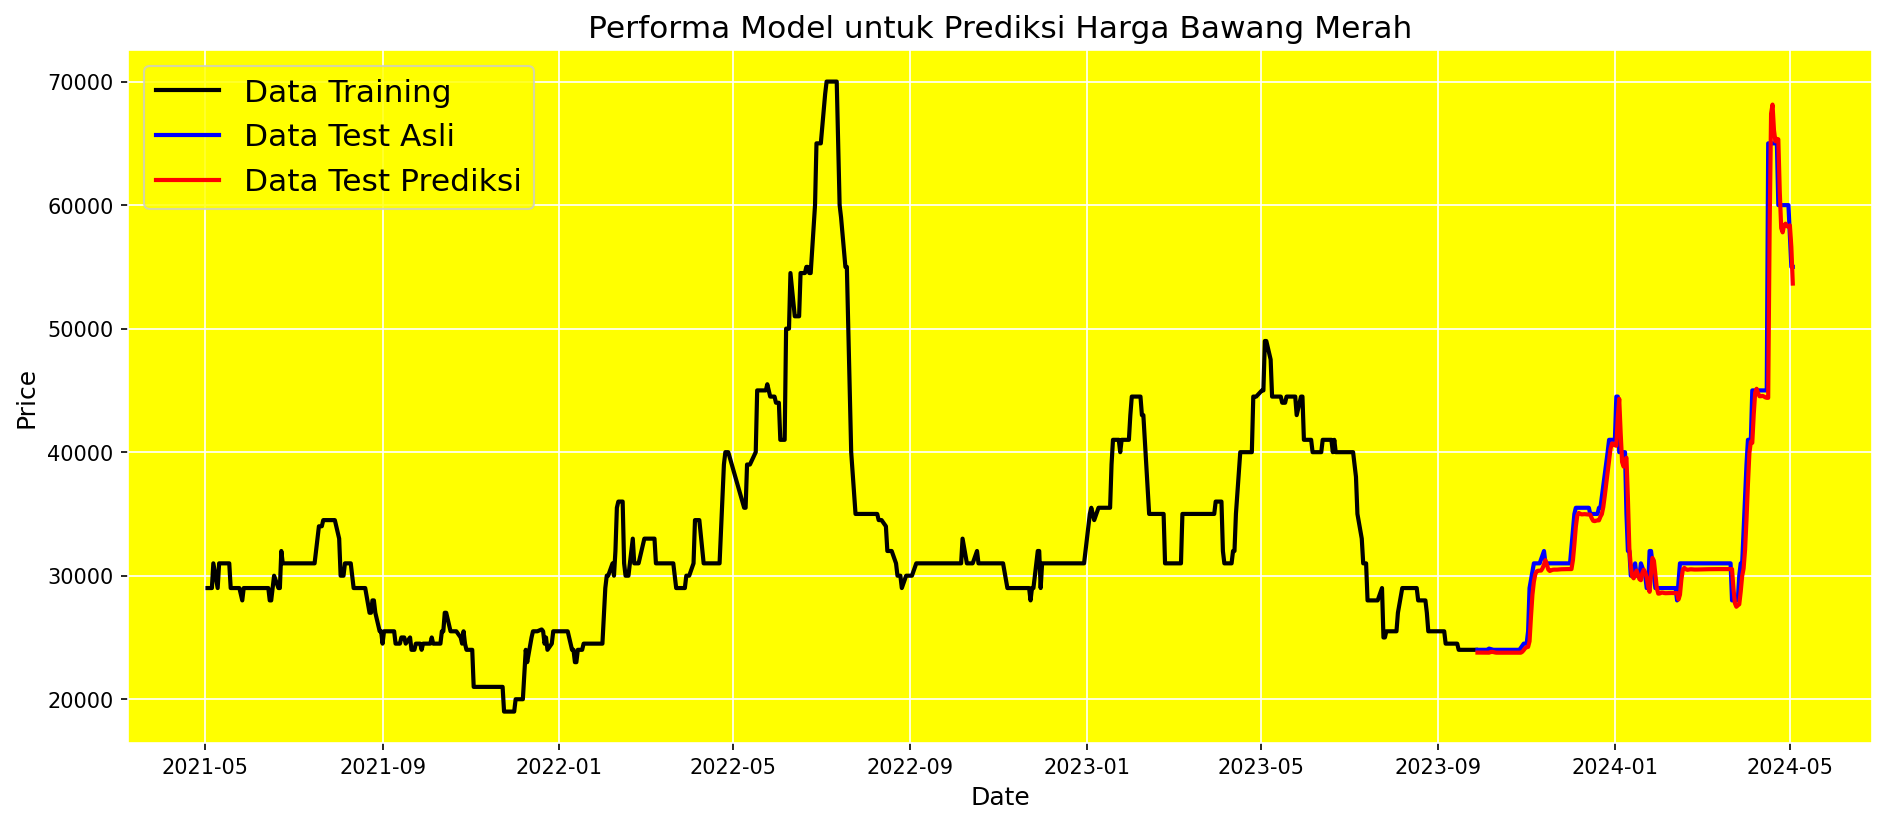

In [90]:
# Visualizing Results

# Mengembalikan nilai yang dinormalisasi ke data yang asli
y_test_true = np.round(scaler.inverse_transform(y_test))
y_test_pred = np.round(scaler.inverse_transform(y_pred))
real_train_data = scaler.inverse_transform(train_data)

# Menggambar Plot
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.date.iloc[:-test_size], real_train_data, color='black', lw=2)
plt.plot(df.date.iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df.date.iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Performa Model untuk Prediksi ' + y_axis_title_comodity[comodity_selected], fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Data Training', 'Data Test Asli', 'Data Test Prediksi'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()



> melakukan visualiasi untuk melihat bagaimana performa model untuk memprediksi (tampilkan data test only)



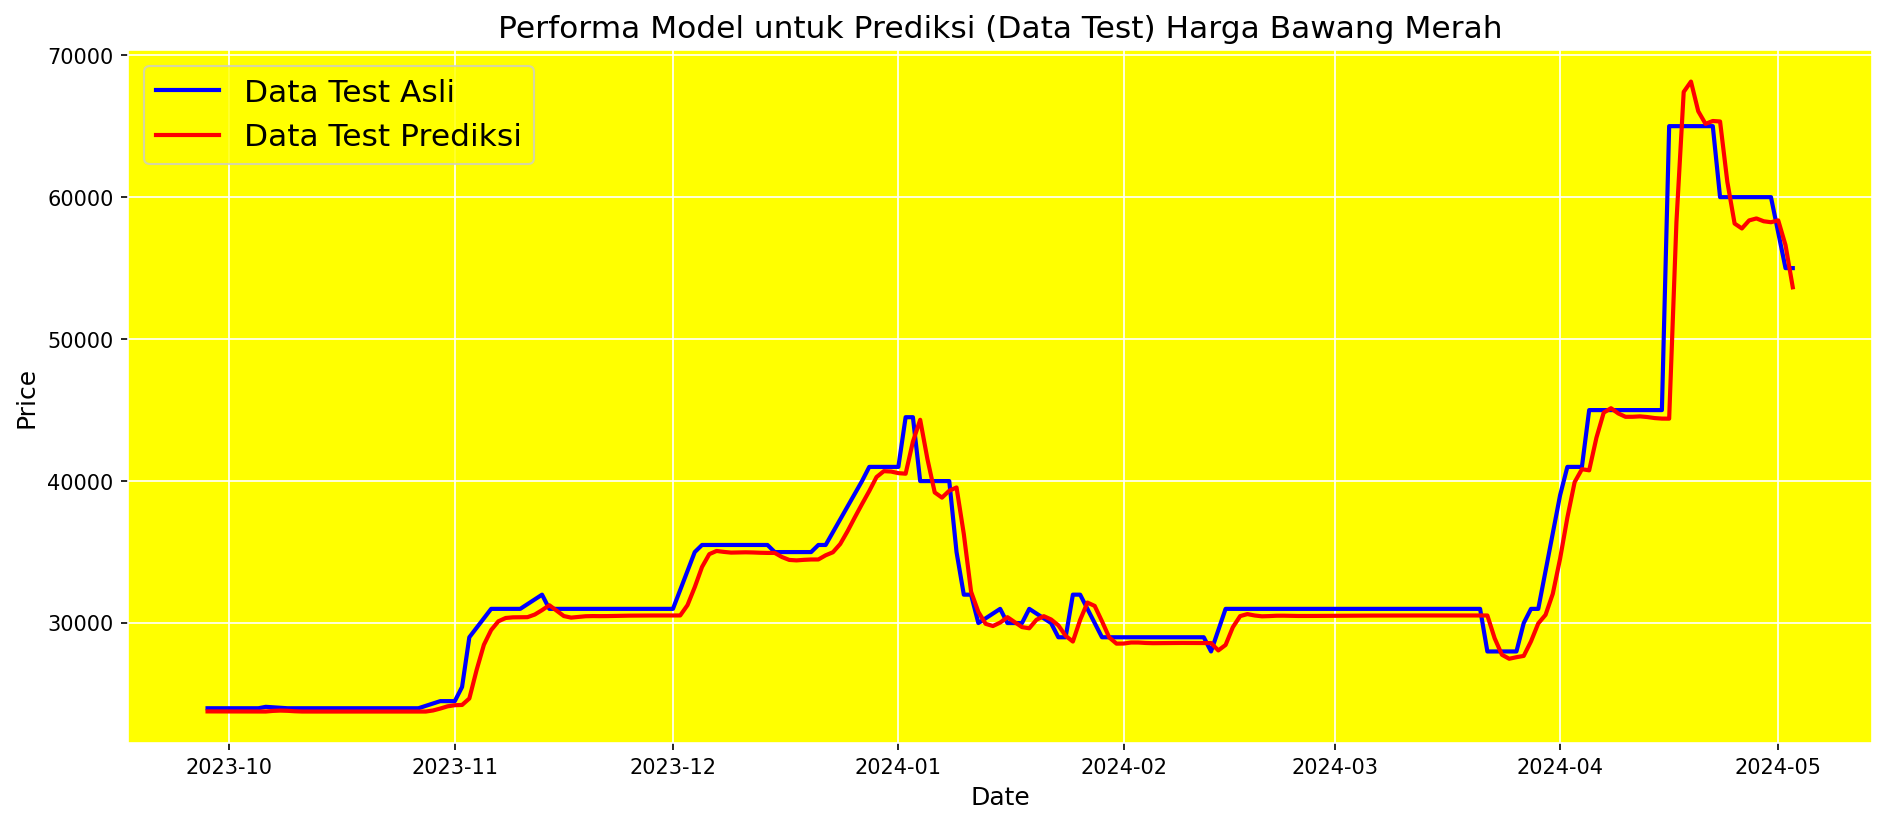

In [91]:
# Menggambar Plot Data Test Only
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.date.iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df.date.iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Performa Model untuk Prediksi (Data Test) ' + y_axis_title_comodity[comodity_selected], fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Data Test Asli', 'Data Test Prediksi'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()



> pada proses ini saya gunakan untuk melihat bagaimana persentase kesalahan hasil prediksi dengan nilai aktual



In [92]:
# Data Perbandingan dalam bentuk tabel
flatent_test_true = [item[0] for item in y_test_true]
flatent_test_pred = [item[0] for item in y_test_pred]

table_data = pd.DataFrame({
    'Date': df['date'].iloc[-test_size:],
    'Harga Asli': flatent_test_true,
    'Harga Prediksi': flatent_test_pred,
})

# Calculate the Percentage Error (often used in Mean Absolute Percentage Error or MAPE)
table_data['Persentase Error'] = ((table_data['Harga Asli'] / table_data['Harga Prediksi']) * 100)

table_data

,Date,Harga Asli,Harga Prediksi,Persentase Error
878,2023-09-28,24000.0,23777.0,100.937881
879,2023-09-29,24000.0,23776.0,100.942127
880,2023-09-30,24000.0,23774.0,100.950618
881,2023-10-01,24000.0,23773.0,100.954865
882,2023-10-02,24000.0,23772.0,100.959112
...,...,...,...,...
1092,2024-04-29,60000.0,58301.0,102.914187
1093,2024-04-30,60000.0,58233.0,103.034362
1094,2024-05-01,57500.0,58361.0,98.524700
1095,2024-05-02,55000.0,56621.0,97.137105


## Test Prediksi (Model Inference)

[[[0.351351]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [1.      ]
  [1.      ]
  [1.      ]
  [1.      ]
  [1.      ]
  [1.      ]
  [1.      ]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.797297]
  [0.72973 ]
  [0.72973 ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[52641.523]
 [51322.227]
 [49817.316]]


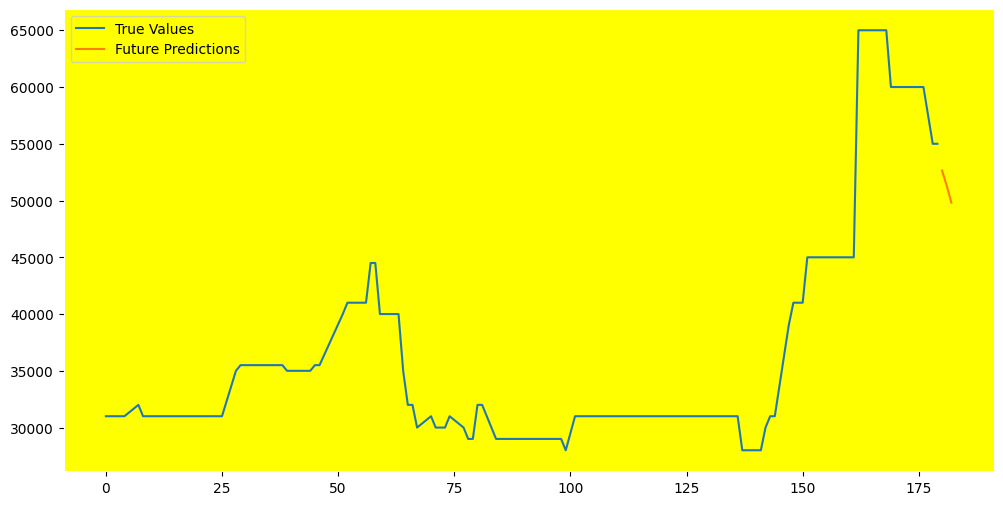

In [93]:
# Memprediksi X Hari Kedepan
target = df[comodity_list[comodity_selected]].tail(180).values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target)

# Membulatkan hingga 4 angka di belakang koma
scaled_target = np.round(scaled_target, 6)

# Predict future values
future_steps = 3  # Set the number of future steps you want to predict
future_data = scaled_target[-window_size:, :]

print(future_data.reshape((1, window_size, 1)))

future_predictions = []
for _ in range(future_steps):
    # Reshape the data to match the input shape of the model
    future_input = future_data.reshape((1, window_size, 1))

    # Make the prediction
    future_pred = model.predict(future_input)

    # Append the prediction to the results
    future_predictions.append(future_pred[0, 0])

    # Update the input data for the next prediction
    future_data = np.vstack((future_data[1:], future_pred))

# Inverse transform the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print(future_predictions)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(target, label='True Values')
plt.plot(np.arange(len(target) , len(target) + future_steps), future_predictions, label='Future Predictions')
plt.legend()
plt.show()